# Problem Statement:
The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies. In this topic ,Google Analytics Customer Revenue Prediction we need to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer.

# Data Wrangling

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import datetime
import math
import matplotlib.mlab as mlab
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [ ]:
def load_df(csv_path='../input/ga-customer-revenue-prediction/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv("../input/ga-customer-revenue-prediction/train.csv", 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df


In [ ]:
train = load_df("../input/ga-customer-revenue-prediction/train.csv")
train.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



Loaded train.csv. Shape: (903653, 55)


,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

In [ ]:
test = load_df("../input/ga-customer-revenue-prediction/test.csv")
test.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



Loaded test.csv. Shape: (903653, 55)


,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

In [ ]:
print(train.info(),test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    903653 non-null  object
 1   date                                               903653 non-null  int64 
 2   fullVisitorId                                      903653 non-null  object
 3   sessionId                                          903653 non-null  object
 4   socialEngagementType                               903653 non-null  object
 5   visitId                                            903653 non-null  int64 
 6   visitNumber                                        903653 non-null  int64 
 7   visitStartTime                                     903653 non-null  int64 
 8   device.browser                                     903653 non-null  object
 9   devi

In [ ]:
print(train.shape,test.shape)

(903653, 55) (903653, 55)


We can now observe that:

train.csv has 903,653 rows and 55 columns.

# Data Preprocessing

Let us look at what all are the numerical variables for both train and test sets

* Train Set:

In [ ]:
numeric_features_train = train.select_dtypes(include=[np.number])
numeric_features_train.columns


Index(['date', 'visitId', 'visitNumber', 'visitStartTime'], dtype='object')

* Test Set:

In [ ]:
numeric_features_test = test.select_dtypes(include=[np.number])

numeric_features_test.columns

Index(['date', 'visitId', 'visitNumber', 'visitStartTime'], dtype='object')

Let us look at what all are the categorical variables for both train and test sets

* Train Set


In [ ]:
categorical_features_train = train.select_dtypes(include=[np.object])
categorical_features_train.columns

Index(['channelGrouping', 'fullVisitorId', 'sessionId', 'socialEngagementType',
       'device.browser', 'device.browserVersion', 'device.browserSize',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.mobileDeviceBranding', 'device.mobileDeviceModel',
       'device.mobileInputSelector', 'device.mobileDeviceInfo',
       'device.mobileDeviceMarketingName', 'device.flashVersion',
       'device.language', 'device.screenColors', 'device.screenResolution',
       'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.cityId',
       'geoNetwork.networkDomain', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits',
       'totals.transactionRevenue', 'trafficSource.campaign',
       'trafficSource.source', '

* Test Set:

In [ ]:
categorical_features_test = test.select_dtypes(include=[np.object])
categorical_features_test.columns

Index(['channelGrouping', 'fullVisitorId', 'sessionId', 'socialEngagementType',
       'device.browser', 'device.browserVersion', 'device.browserSize',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.mobileDeviceBranding', 'device.mobileDeviceModel',
       'device.mobileInputSelector', 'device.mobileDeviceInfo',
       'device.mobileDeviceMarketingName', 'device.flashVersion',
       'device.language', 'device.screenColors', 'device.screenResolution',
       'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.cityId',
       'geoNetwork.networkDomain', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits',
       'totals.transactionRevenue', 'trafficSource.campaign',
       'trafficSource.source', '

Let us now explore the missing values in both train and test sets.

It is observed that there are some columns that contains "not available in demo dataset" as constant values predominently.So it is not going to be effective if we use these columns in our model prediction.So we can safely delete these features from both train and test datasets as below.

In [ ]:
print ("Before removing constant columns - shape of train & test datasets: ", train.shape,test.shape)
train = train.loc[:, (train != train.iloc[0]).any()]
test = test.loc[:, (test != test.iloc[0]).any()]
print ("After Removing Constant Columns - shape of train & test datasets: ", train.shape,test.shape)


Before removing constant columns - shape of train & test datasets:  (903653, 55) (903653, 55)
After Removing Constant Columns - shape of train & test datasets:  (903653, 36) (903653, 36)


In [ ]:
train.head(3)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,ttnet.com.tr,1,1,1,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,Macintosh,False,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,1,1,1,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,Windows,False,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,unknown.unknown,1,1,1,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 36 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------                                        --------------   ----- 
 0   channelGrouping                               903653 non-null  object
 1   date                                          903653 non-null  int64 
 2   fullVisitorId                                 903653 non-null  object
 3   sessionId                                     903653 non-null  object
 4   visitId                                       903653 non-null  int64 
 5   visitNumber                                   903653 non-null  int64 
 6   visitStartTime                                903653 non-null  int64 
 7   device.browser                                903653 non-null  object
 8   device.operatingSystem                        903653 non-null  object
 9   device.isMobile                               903653 non-nu

In [ ]:
test.head(3)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,ttnet.com.tr,1,1,1,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,Macintosh,False,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,1,1,1,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,Windows,False,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,unknown.unknown,1,1,1,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Missing values for all categorical features in Bar chart Representation

* Train set

In [ ]:
total_test = categorical_features_train.isnull().sum().sort_values(ascending=False)
percent = (categorical_features_train.isnull().sum()/categorical_features_train.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total_test, percent], axis=1,join='outer', keys=['Total Missing Count', ' % of Total Observations'])
missing_data.index.name ='Feature'
missing_data.head(14)

,Total Missing Count,% of Total Observations
Feature,,
trafficSource.campaignCode,903652,99.999889
trafficSource.adContent,892707,98.788694
totals.transactionRevenue,892138,98.725728
trafficSource.adwordsClickInfo.isVideoAd,882193,97.625195
trafficSource.adwordsClickInfo.adNetworkType,882193,97.625195
trafficSource.adwordsClickInfo.slot,882193,97.625195
trafficSource.adwordsClickInfo.page,882193,97.625195
trafficSource.adwordsClickInfo.gclId,882092,97.614018
trafficSource.isTrueDirect,629648,69.678073


Let us visualise the missing categorical features for train set:

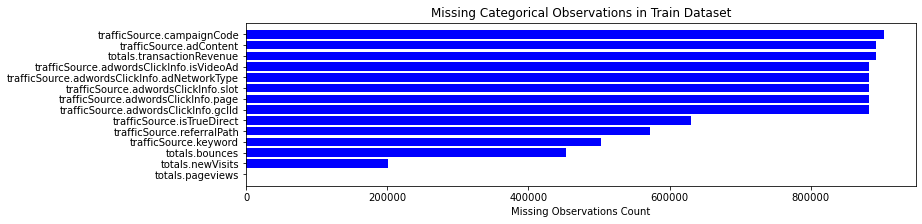

In [ ]:
missing_values = categorical_features_train.isnull().sum(axis=0).reset_index()
missing_values.columns = ['column_name', 'missing_count']
missing_values = missing_values.loc[missing_values['missing_count']>0]
missing_values = missing_values.sort_values(by='missing_count')
ind = np.arange(missing_values.shape[0])
width = 0.1
fig, ax = plt.subplots(figsize=(12,3))
rects = ax.barh(ind, missing_values.missing_count.values, color='b')
ax.set_yticks(ind)
ax.set_yticklabels(missing_values.column_name.values, rotation='horizontal')
ax.set_xlabel("Missing Observations Count")
ax.set_title("Missing Categorical Observations in Train Dataset")
plt.show()

In [ ]:
total_test = categorical_features_test.isnull().sum().sort_values(ascending=False)
percent = (categorical_features_test.isnull().sum()/categorical_features_test.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total_test, percent], axis=1,join='outer', keys=['Total Missing Count', ' % of Total Observations'])
missing_data.index.name ='Feature'
missing_data.head(12)

,Total Missing Count,% of Total Observations
Feature,,
trafficSource.campaignCode,903652,99.999889
trafficSource.adContent,892707,98.788694
totals.transactionRevenue,892138,98.725728
trafficSource.adwordsClickInfo.isVideoAd,882193,97.625195
trafficSource.adwordsClickInfo.adNetworkType,882193,97.625195
trafficSource.adwordsClickInfo.slot,882193,97.625195
trafficSource.adwordsClickInfo.page,882193,97.625195
trafficSource.adwordsClickInfo.gclId,882092,97.614018
trafficSource.isTrueDirect,629648,69.678073


Let us visualise the missing categorical features test:

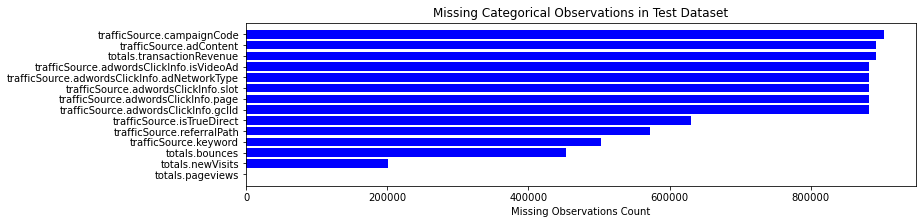

In [ ]:
missing_values = categorical_features_test.isnull().sum(axis=0).reset_index()
missing_values.columns = ['column_name', 'missing_count']
missing_values = missing_values.loc[missing_values['missing_count']>0]
missing_values = missing_values.sort_values(by='missing_count')
ind = np.arange(missing_values.shape[0])
width = 0.1
fig, ax = plt.subplots(figsize=(12,3))
rects = ax.barh(ind, missing_values.missing_count.values, color='b')
ax.set_yticks(ind)
ax.set_yticklabels(missing_values.column_name.values, rotation='horizontal')
ax.set_xlabel("Missing Observations Count")
ax.set_title("Missing Categorical Observations in Test Dataset")
plt.show()

In [ ]:
# Replace NaN values throughout train dataset
train.replace(to_replace=np.nan, value=0, inplace=True)
train.shape

(903653, 55)

In [ ]:
# Replace NaN values throughout test dataset
test.replace(to_replace=np.nan, value=0, inplace=True)
test.shape

(903653, 55)

In [ ]:
cor=train.corr()
cor

,date,visitId,visitNumber,visitStartTime,device.isMobile
date,1.000000,0.880936,0.007536,0.880936,0.146148
visitId,0.880936,1.000000,0.002069,1.000000,0.144332
visitNumber,0.007536,0.002069,1.000000,0.002069,-0.037667
visitStartTime,0.880936,1.000000,0.002069,1.000000,0.144332
device.isMobile,0.146148,0.144332,-0.037667,0.144332,1.000000


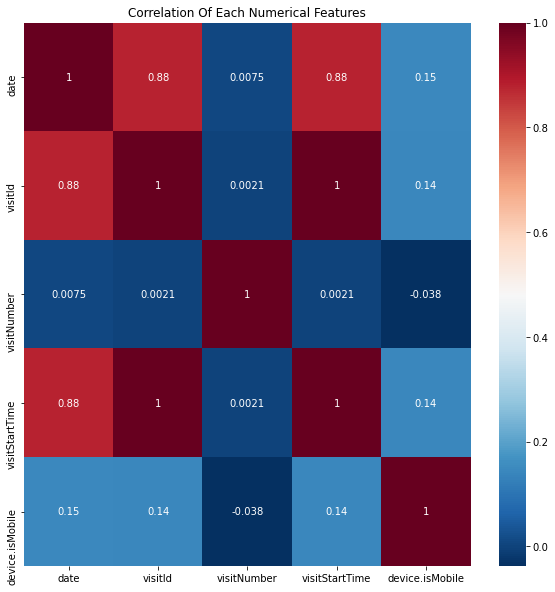

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(),annot=True,cmap='RdBu_r')
plt.title("Correlation Of Each Numerical Features")
plt.show()

In [ ]:
cor1=test.corr()
cor1

,date,visitId,visitNumber,visitStartTime,device.isMobile
date,1.000000,0.880936,0.007536,0.880936,0.146148
visitId,0.880936,1.000000,0.002069,1.000000,0.144332
visitNumber,0.007536,0.002069,1.000000,0.002069,-0.037667
visitStartTime,0.880936,1.000000,0.002069,1.000000,0.144332
device.isMobile,0.146148,0.144332,-0.037667,0.144332,1.000000


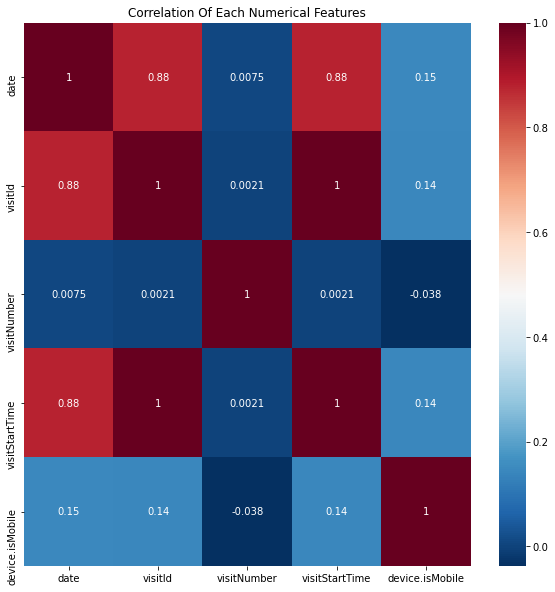

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(test.corr(),annot=True,cmap='RdBu_r')
plt.title("Correlation Of Each Numerical Features")
plt.show()

# Data Visualization and Exploratory Data Analysis

Univariate Analysis:
Lets perform univariate analysis on some of the variables in the dataset and plot their distributions to unfold patterns or insights about the data

Geo Network Attributes:
* geoNetwork_city
* geoNetwork_continent
* geoNetwork_country
* geoNetwork_metro
* geoNetwork_networkDomain
* geoNetwork_region
* geoNetwork_subContinent
So among the above geoNetwork attributes let us consider 'geoNetwork_country' attribute and visualise customer revenue

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
colorscale = [[0, 'rgb(102,194,165)'], [0.0005, 'rgb(102,194,165)'], 
              [0.01, 'rgb(171,221,164)'], [0.02, 'rgb(230,245,152)'], 
              [0.04, 'rgb(255,255,191)'], [0.05, 'rgb(254,224,139)'], 
              [0.10, 'rgb(253,174,97)'], [0.25, 'rgb(213,62,79)'], [1.0, 'rgb(158,1,66)']]

data = [ dict(
        type = 'choropleth',
        autocolorscale = False,
        colorscale = colorscale,
        showscale = True,
        locations = train["geoNetwork.country"].value_counts().index,
        locationmode = 'country names',
        z = train["geoNetwork.country"].value_counts().values,
        marker = dict(
            line = dict(color = 'rgb(250,250,225)', width = 1)),
            colorbar = dict( title = 'Customer Visits ')
            ) 
       ]

layout = dict(
    height=600,
    title = 'World Wide Customer Visit Distribution',
    geo = dict(
        showframe = True,
        showocean = True,
        oceancolor = 'rgb(28,107,160)',
        projection = dict(
        type = 'orthographic',
            rotation = dict(
                    lon = 50,
                    lat = 10),
        ),
        lonaxis =  dict(
                showgrid = True,
                gridcolor = 'rgb(12, 102, 102)'
            ),
        lataxis = dict(
                showgrid = True,
                gridcolor = 'rgb(12, 102, 102)'
                )
            ),
        )
fig = dict(data=data, layout=layout)
iplot(fig)

Inferences:
* On the continent plot, we can see that America has both higher number of counts as well as highest number of counts where the revenue is non-zero
* Though Asia and Europe has high number of counts, the number of non-zero revenue counts from these continents are comparatively low.

Target Variable Exploration:

Since we are predicting the natural log of sum of all transactions of the user, let us sum up the transaction revenue at user level and take a log and then do a scatter plot

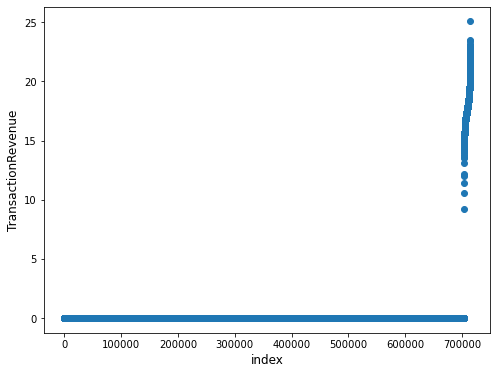

In [ ]:
train["totals.transactionRevenue"] = train["totals.transactionRevenue"].astype('float')
gdf = train.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

This confirms the first two lines of the competition overview:
* The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.

Checking the ratio:

In [ ]:
nzi = pd.notnull(train["totals.transactionRevenue"]).sum()
nzr = (gdf["totals.transactionRevenue"]>0).sum()
print("Number of instances in train set with non-zero revenue : ", nzi, " and ratio is : ", nzi / train.shape[0])
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / gdf.shape[0])

Number of instances in train set with non-zero revenue :  11515  and ratio is :  0.0127427231470487
Number of unique customers with non-zero revenue :  9996 and the ratio is :  0.013996726255903731


So the ratio of revenue generating customers to customers with no revenue is in the ratio close to 1.3%

Since most of the rows have non-zero revenues, in the following plots let us have a look at the count of each category of the variable along with the number of instances where the revenue is not zero

Number of visitors and common visitors

In [ ]:
print("Number of unique visitors in train set : ",train.fullVisitorId.nunique(), " out of rows : ",train.shape[0])
print("Number of unique visitors in test set : ",test.fullVisitorId.nunique(), " out of rows : ",test.shape[0])
print("Number of common visitors in train and test set : ",len(set(train.fullVisitorId.unique()).intersection(set(test.fullVisitorId.unique())) ))

Number of unique visitors in train set :  714167  out of rows :  903653
Number of unique visitors in test set :  714167  out of rows :  903653
Number of common visitors in train and test set :  714167


Device Information:

In [ ]:

def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Device Browser
cnt_srs = train.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(50, 171, 96, 0.6)')

# Device Category
cnt_srs = train.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(71, 58, 131, 0.8)')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(71, 58, 131, 0.8)')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(71, 58, 131, 0.8)')

# Operating system
cnt_srs = train.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(246, 78, 139, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10),'rgba(246, 78, 139, 0.6)')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10),'rgba(246, 78, 139, 0.6)')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Device Browser - Count", "Device Browser - Non-zero Revenue Count", "Device Browser - Mean Revenue",
                                          "Device Category - Count",  "Device Category - Non-zero Revenue Count", "Device Category - Mean Revenue", 
                                          "Device OS - Count", "Device OS - Non-zero Revenue Count", "Device OS - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
py.iplot(fig, filename='device-plots')

/opt/conda/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



Inferences:
* Device browser distribution looks similar on both the count and count of non-zero revenue plots
* On the device category front, desktop seem to have higher percentage of non-zero revenue counts compared to mobile devices
* In device operating system, though the number of counts is more from windows, the number of counts where revenue is not zero is more for Macintosh.
* Chrome OS also has higher percentage of non-zero revenue counts
* On the mobile OS side, iOS has more percentage of non-zero revenue counts compared to Android

Date Exploration for datetime instance


In [ ]:
import datetime

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

train['date'] = train['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = train.groupby('date')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_index()
#cnt_srs.index = cnt_srs.index.astype('str')
trace1 = scatter_plot(cnt_srs["count"], 'red')
trace2 = scatter_plot(cnt_srs["count of non-zero revenue"], 'blue')

fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Count", "Date - Non-zero Revenue count"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')

Inferences:
* We have data from 1 Aug, 2016 to 31 July, 2017 in our training dataset
* In Nov 2016, though there is an increase in the count of visitors, there is no increase in non-zero revenue counts during that time period (relative to the mean).

In [ ]:
test['date'] = test['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = test.groupby('date')['fullVisitorId'].size()


trace = scatter_plot(cnt_srs, 'red')

layout = go.Layout(
    height=400,
    width=800,
    paper_bgcolor='rgb(233,233,233)',
    title='Dates in Test set'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

In the test set, we have dates from 2 Aug, 2017 to 30 Apr, 2018. So there are no common dates between train and test set. So it might be a good idea to do time based validation for this dataset.

Traffic Source:

In [ ]:
# Continent
cnt_srs = train.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'green')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'green')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'green')

# Sub-continent
cnt_srs = train.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'purple')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'purple')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'purple')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Traffic Source - Count", "Traffic Source - Non-zero Revenue Count", "Traffic Source - Mean Revenue",
                                          "Traffic Source Medium - Count",  "Traffic Source Medium - Non-zero Revenue Count", "Traffic Source Medium - Mean Revenue"
                                          ])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1000, width=1200, paper_bgcolor='rgb(233,233,233)', title="Traffic Source Plots")
py.iplot(fig, filename='traffic-source-plots')


Inferences:
* In the traffic source plot, though Youtube has high number of counts in the dataset, the number of non-zero revenue counts are very less.
* Google plex has a high ratio of non-zero revenue count to total count in the traffic source plot.
* On the traffic source medium, "referral" has more number of non-zero revenue count compared to "organic" medium.

Visitor Profile:
Now let us look at the visitor profile variables like number of pageviews by the visitor, number of hits by the visitor and see how they look.

In [ ]:
# Page views
cnt_srs = train.groupby('totals.pageviews')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(60), 'cyan')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'cyan')
trace5 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'cyan')

# Hits
cnt_srs = train.groupby('totals.hits')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", 'mean']
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace3 = horizontal_bar_chart(cnt_srs["count"].head(60), 'black')
trace4 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'black')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'black')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Total Pageviews - Count", "Total Pageviews - Non-zero Revenue Count", "Total Pageviews - Mean Revenue",
                                          "Total Hits - Count",  "Total Hits - Non-zero Revenue Count", "Total Hits - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace5, 1, 3)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Visitor Profile Plots")
py.iplot(fig, filename='visitor-profile-plots')

Inferences:
* Count plot shows decreasing nature i.e. we have a very high total count for less number of hits and page views per visitor transaction and the overall count decreases when the number of hits per visitor transaction increases.
* On the other hand, we can clearly see that when the number of hits / pageviews per visitor transaction increases, we see that there is a high number of non-zero revenue counts.

In [ ]:
def line_plot(train):
    f, axes = plt.subplots(figsize=(18, 6))

    sns.set(style="white")
    sns.lineplot( data=train, palette="tab10", linewidth=2.5)

    plt.tight_layout()

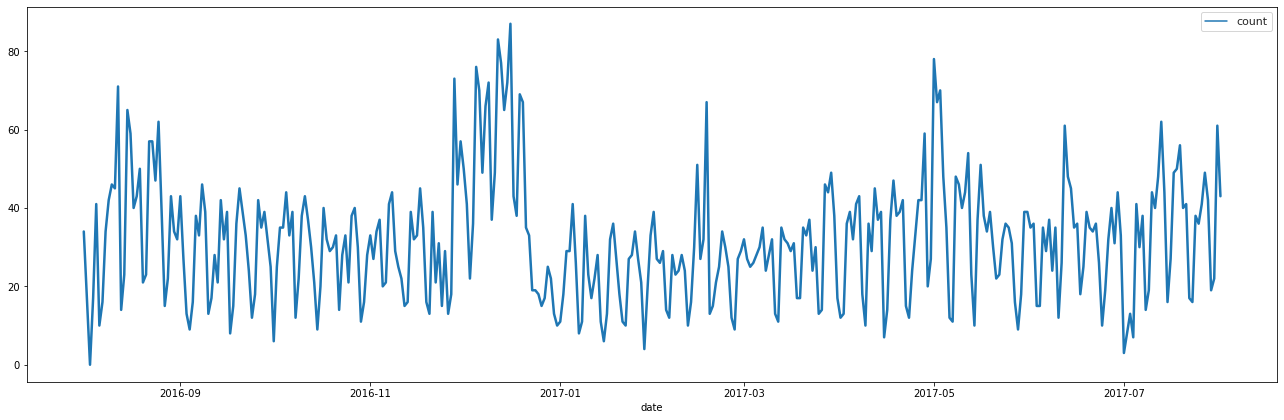

In [ ]:
data = train.groupby("date")["totals.transactionRevenue"].agg(['count'])
line_plot(data)

Inferences:
* The number of transactions is up in December, likely in-line with Christmas
* There appears to be no increasing trend from the beginning of the dataset to the end
Seasonality is apparent

In [ ]:
data = test.groupby("date")["fullVisitorId"].agg(['size'])
line_plot(data)

The test dataset shows a very large spike around December, much larger than any in the training dataset

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

agg_dict = {}
for col in ["totals.bounces", "totals.hits", "totals.newVisits", "totals.pageviews", "totals.transactionRevenue"]:
    train[col] = train[col].astype('float')
    agg_dict[col] = "sum"
tmp = train.groupby("fullVisitorId").agg(agg_dict).reset_index()
tmp.head()

,fullVisitorId,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue
0,0000010278554503158,0.0,11.0,1.0,8.0,0.0
1,0000020424342248747,0.0,17.0,1.0,13.0,0.0
2,0000027376579751715,0.0,6.0,1.0,5.0,0.0
3,0000039460501403861,0.0,2.0,1.0,2.0,0.0
4,0000040862739425590,0.0,5.0,1.0,5.0,0.0


Total Revenue Distribution:
Looking at the distribution of total revenue without normalisation

There are 9996 visitors in the train dataset having non zero total transaction revenue


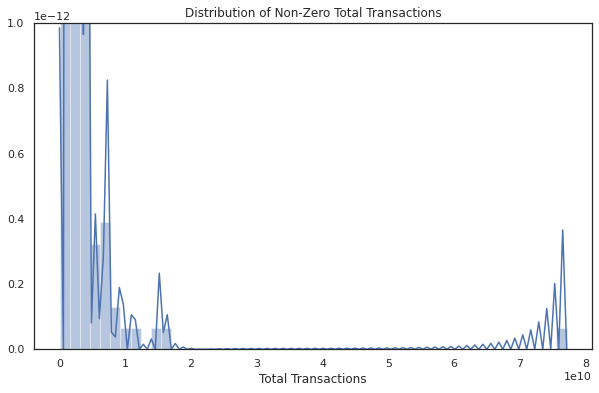

In [ ]:
non_zero = tmp[tmp["totals.transactionRevenue"] > 0]["totals.transactionRevenue"]
print ("There are " + str(len(non_zero)) + " visitors in the train dataset having non zero total transaction revenue")

plt.figure(figsize=(10,6))
sns.distplot(non_zero)
plt.title("Distribution of Non-Zero Total Transactions");
plt.xlabel("Total Transactions");

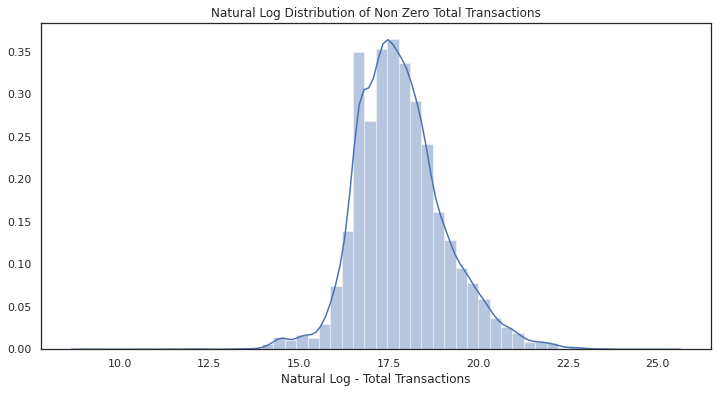

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(np.log1p(non_zero))
plt.title("Natural Log Distribution of Non Zero Total Transactions");
plt.xlabel("Natural Log - Total Transactions");

In [ ]:
print("Variables not in test but in train : ", set(train.columns).difference(set(test.columns)))

Variables not in test but in train :  set()


In [ ]:
## find constant columns
constant_columns = []
for col in train.columns:
    if len(train[col].value_counts()) == 1:
        constant_columns.append(col)

## non relevant columns
non_relevant = ["visitNumber", "date", "fullVisitorId", "sessionId", "visitId", "visitStartTime"]

In [ ]:
print(constant_columns)

['totals.bounces', 'totals.newVisits', 'trafficSource.isTrueDirect', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.campaignCode']


In [ ]:
cols_to_drop = constant_columns + ['sessionId']
train = train.drop(cols_to_drop + ["trafficSource.campaignCode"], axis=1)
test = test.drop(cols_to_drop, axis=1)

# Principal Component Analysis

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import datasets

In [ ]:
X = StandardScaler().fit_transform(train)
X

array([[-1.09867985, -1.09867985, -1.34967236, -0.13624881, -1.34967245],
       [-1.3443078 , -1.3443078 , -1.34415681, -0.13624881, -1.3441569 ],
       [-0.19872143, -0.19872143, -1.3457929 , -0.13624881, -1.34579299],
       ...,
       [ 0.40334774,  0.40334774, -0.16413607, -0.13624881, -0.16413618],
       [-0.58496112, -0.58496112, -0.15677383, -0.13624881, -0.15677316],
       [-1.20182126, -1.20182126, -0.15881138, -0.13624881, -0.15881148]])

In [ ]:
# Create a PCA that will retain 99% of the variance
pca = PCA(n_components=0.80, whiten=True)

In [ ]:
X_pca = pca.fit_transform(X)

In [ ]:
X_pca

array([[-0.05694737, -1.73789062],
       [-0.25577093, -1.88185702],
       [ 0.65698334, -1.1912069 ],
       ...,
       [ 0.42286198,  0.11452106],
       [-0.36817269, -0.47656521],
       [-0.85789849, -0.8507844 ]])

Calculating accuracy for x and xpca

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

(-2.729271205627196,
 2.570274439335261,
 -0.9326181575178751,
 1.0044138302291827)

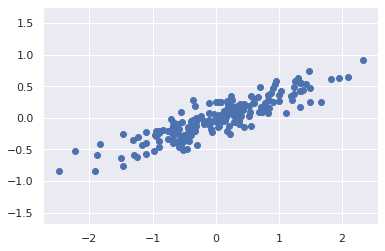

In [ ]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [ ]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [ ]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


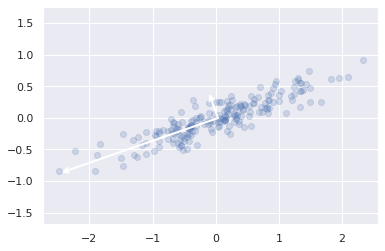

In [ ]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

In [ ]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


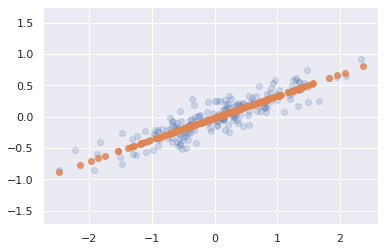

In [ ]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

# Cluster Analysis

In [ ]:
import random 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.



In [ ]:

from sklearn.preprocessing import StandardScaler
X = train.values[:,1:]

Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[-1.09867985, -1.34967236, -0.13624881, -1.34967245],
       [-1.3443078 , -1.34415681, -0.13624881, -1.3441569 ],
       [-0.19872143, -1.3457929 , -0.13624881, -1.34579299],
       ...,
       [ 0.40334774, -0.16413607, -0.13624881, -0.16413618],
       [-0.58496112, -0.15677383, -0.13624881, -0.15677316],
       [-1.20182126, -0.15881138, -0.13624881, -0.15881148]])

Modeling:Lets apply k-means on our dataset, and take look at cluster labels.

In [ ]:
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)\

[1 1 2 ... 2 1 1]


Insights:We assign the labels to each row in dataframe.

In [ ]:
train["Clus_km"] = labels
train.head(5)

,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,Clus_km
0,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,1
1,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,1
2,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,2
3,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,2
4,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,1


We can easily check the centroid values by averaging the features in each cluster.

In [ ]:
train.groupby('Clus_km').mean()

,visitId,visitNumber,visitStartTime
Clus_km,,,
0,1.485025e+09,1.972871,1.485025e+09
1,1.485012e+09,2.479489,1.485012e+09
2,1.484984e+09,2.301042,1.484984e+09


Now, lets look at the distribution based on their visitId and visitNumber :

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:2272: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



<Figure size 720x720 with 0 Axes>

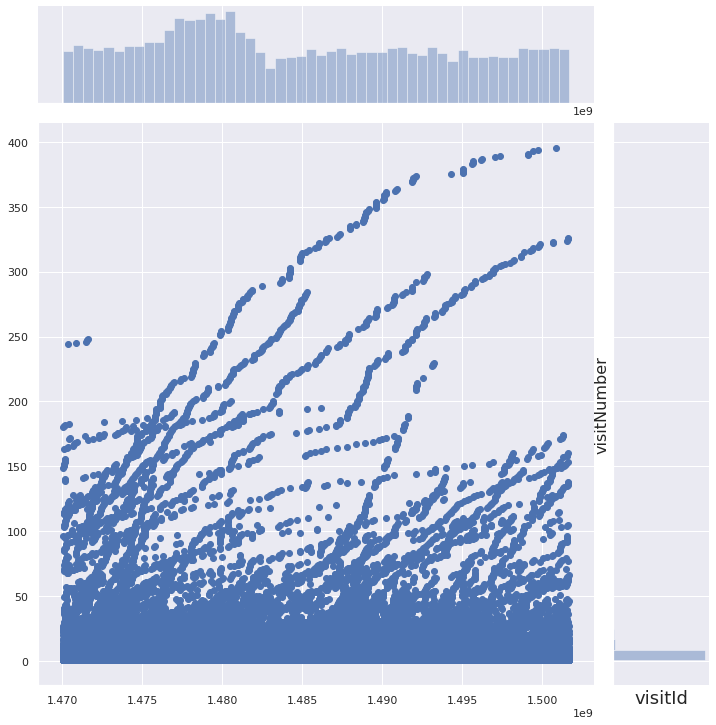

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [ ]:
plt.figure(figsize=(10,10))
sns.jointplot(x=train.visitId.values,y=train.visitNumber.values,size=10)
plt.xlabel('visitId', fontsize=18)
plt.ylabel('visitNumber', fontsize=16)

plt.show()
sns.despine


# Model Building

Creating development and validation splits based on time to build the model. We can take the last two months as validation sample.

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Impute 0 for missing target values
train["totals.transactionRevenue"].fillna(0, inplace=True)
train_y = train["totals.transactionRevenue"].values
train_id = train["fullVisitorId"].values
test_id = test["fullVisitorId"].values
# label encode the categorical variables and convert the numerical variables to float
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent"]
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))
    num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime"]    
for col in num_cols:
    train[col] = train[col].astype(float)
    test[col] = test[col].astype(float)

# Split the train dataset into development and valid based on time 
dev_df = train[train['date']<=datetime.date(2017,5,31)]
val_df = train[train['date']>datetime.date(2017,5,31)]
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)
dev_X = dev_df[cat_cols + num_cols] 
val_X = val_df[cat_cols + num_cols] 
test_X = test[cat_cols + num_cols] 

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent


**Light Gradient Boosting(With Hypertuning)**

In [ ]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.70265
[200]	valid_0's rmse: 1.6981
[300]	valid_0's rmse: 1.69744
Early stopping, best iteration is:
[259]	valid_0's rmse: 1.6959


Computing the evaluation metric on the validation data. So we need to do a sum for all the transactions of the user and then do a log transformation on top. Let us also make the values less than 0 to 0 as transaction revenue can only be 0 or more.

In [ ]:
from sklearn import metrics
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
#print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

1.7141364781423158


So we are getting a validation score of 1.70 using this method against the public leaderboard score of 1.44. 

In [ ]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("baseline_lgb.csv", index=False)

In [ ]:
sub_df.head()

,fullVisitorId,PredictedLogRevenue
0,0000010278554503158,0.000000
1,0000020424342248747,0.012113
2,0000027376579751715,0.000000
3,0000039460501403861,0.000000
4,0000040862739425590,0.000000


Here is the output that is the predicted Log Revenue depending on the customer data.